<a href="https://colab.research.google.com/github/Vz-3/AP-DS/blob/main/audioFeatureExtraction/FA6-AudioFeatureExtraction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

wavDittoPath = '/content/drive/MyDrive/datasets/raw_files/Ditto_chorus.wav'
wavColdManPath =  '/content/drive/MyDrive/datasets/raw_files/ColdColdColdman_chorus.wav'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
%matplotlib inline
import librosa
import IPython.display as IPod
from sklearn import preprocessing
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

Documentation for Quick Access:
* https://librosa.org/doc/latest/generated/librosa.display.waveshow.html#librosa.display.waveshow
* https://numpy.org/doc/
* https://matplotlib.org/


Raw chorus files:
*   Ditto - NewJeans - 1 min - K-Pop
*   Cold Cold Cold Man - Saint Motel - 1 min - Alt Rock

In [ ]:
from pandas.core.window.numba_ import generate_numba_apply_func
class FeatureExtraction():
    def __init__(self, path, genre):
        thisWave, thisSamplingRate = librosa.load(path)
        self.path = path
        self.genre = generate_numba_apply_func
        self.wave = thisWave
        self.samplingRate = thisSamplingRate
        print("Success!")

    def extractAll(self):
        extractedFeaturesList = []
        extractedFeaturesList.append(self.genre)
        extractedFeaturesList.append(self.extractBeatsPerMinute())
        extractedFeaturesList.append(self.extractChroma())
        extractedFeaturesList.append(self.extractMFCC())
        mag, rms = self.extractRootMeanSquare()
        extractedFeaturesList.append(rms)
        extractedFeaturesList.append(self.extractSpectralCentroid())
        extractedFeaturesList.append(self.extractSpectralRolloff())
        extractedFeaturesList.append(self.extractZeroCrossingRate())
        return extractedFeaturesList

    def extractBeatsPerMinute(self):
        tempo, bpm_frames = librosa.beat.beat_track(y=self.wave, sr=self.samplingRate)
        return tempo

    def extractChroma(self, hopLength=512):
        chromagram = librosa.feature.chroma_stft(y=self.wave, sr=self.samplingRate, hop_length=hopLength)
        return chromagram

    def extractMFCC(self):
        mfcc = librosa.feature.mfcc(y=self.wave, sr=self.samplingRate)
        return mfcc

    def extractRootMeanSquare(self):
        #Loudness or Energy
        magnitude, phase = librosa.magphase(librosa.stft(self.wave))
        rootMeanSquare = librosa.feature.rms(S=magnitude)
        return magnitude, rootMeanSquare

    def extractSpectralCentroid(self):
        spectralCentroid = librosa.feature.spectral_centroid(y=self.wave, sr=self.samplingRate)[0]
        return spectralCentroid

    def extractSpectralRolloff(self):
        spectralRolloff = librosa.feature.spectral_rolloff(y=self.wave, sr=self.samplingRate)[0]
        return spectralRolloff

    def extractZeroCrossingRate(self, whole=True, zoomValuePercentage=0.01, figX=20, figY=5):
        if whole:
            zeroCrossingsWhole = librosa.zero_crossings(self.wave, pad=False)
            return zeroCrossingsWhole
        else:
            import math
            from random import randrange
            startZoom = randrange(1, self.wave.size//2)
            endZoom = startZoom + math.floor(self.wave.size*zoomValuePercentage)
            endZoom2 = startZoom + math.floor(endZoom * 0.01)
            zeroCrossingsFraction = librosa.zero_crossings(self.wave[startZoom:endZoom2], pad=False)
            return zeroCrossingsFraction

    def normalize(self, x, axis=0):
        return preprocessing.minmax_scale(x, axis=axis)

    def visualizeBeatsPerMinute(self, figX=20, figY=5):
        hopLength = 512
        tempo, bpm_frames = librosa.beat.beat_track(y=self.wave, sr=self.samplingRate)
        fig, ax = plt.subplots(nrows=2, sharex=True, figsize=(figX,figY))
        onsetEnvelope = librosa.onset.onset_strength(y=self.wave, sr=self.samplingRate, aggregate=np.median)
        times = librosa.times_like(onsetEnvelope, sr=self.samplingRate, hop_length=hopLength)
        mel = librosa.feature.melspectrogram(y=self.wave, sr=self.samplingRate, hop_length=hopLength)
        librosa.display.specshow(librosa.power_to_db(mel, ref=np.max), y_axis='mel', x_axis='time', hop_length=hopLength, ax=ax[0])

        ax[0].label_outer()
        ax[0].set(title='Mel spectrogram')
        ax[1].plot(times, librosa.util.normalize(onsetEnvelope),
                label='Onset strength')
        ax[1].vlines(times[bpm_frames], 0, 1, alpha=0.5, color='r',
                linestyle='--', label='Beats')
        ax[1].legend()

    def visualizeChroma(self, chromagram, hopLength=512, figX=20, figY=5):
        fig, ax = fig, ax = plt.subplots(figsize=(figX, figY))
        visuals = librosa.display.specshow(chromagram, x_axis='time', y_axis='chroma', hop_length=hopLength, cmap='coolwarm')
        fig.colorbar(visuals, ax=ax)
        pass

    def visualizeMFCC(self, mfcc, figX=20, figY=5):
        plt.figure(figsize=(figX, figY))
        plt.title("Spectogram")
        librosa.display.specshow(mfcc, sr=self.samplingRate, x_axis='time')
        plt.colorbar()

    def visualizeRMS(self, magnitude, rootMeanSquare, figX=20, figY=5):
        fig, ax = plt.subplots(nrows=2, sharex=True, figsize=(figX, figY))
        times = librosa.times_like(rootMeanSquare)
        ax[0].semilogy(times, rootMeanSquare[0], label='RMS Energy')
        ax[0].set(xticks=[])
        ax[0].legend()
        ax[0].label_outer()
        librosa.display.specshow(librosa.amplitude_to_db(magnitude, ref=np.max),
                                y_axis='log', x_axis='time', ax=ax[1])
        ax[1].set(title='Log Power spectrogram')

    def visualizeSpectogram(self, figX=20, figY=5, xAxis = 'time', yAxis='hz'):
        stft = librosa.stft(self.wave)
        db = librosa.amplitude_to_db(abs(stft))
        plt.figure(figsize=(figX, figY))
        plt.title("Spectogram")
        librosa.display.specshow(db, sr=self.samplingRate, x_axis=xAxis, y_axis=yAxis)
        plt.colorbar()

    def visualizeSpectralCentroid(self, spectral, figX=20, figY=5):
        #can only be spectral centroid or rolloff
        frames = range(len(spectral))
        time = librosa.frames_to_time(frames)
        plt.figure(figsize=(figX, figY))
        librosa.display.waveshow(self.wave, sr=self.samplingRate, alpha=0.4)
        plt.title("Spectral Centroid")
        plt.plot(time, self.normalize(spectral), color='r')

    def visualizeSpectralRolloff(self, spectral, figX=20, figY=5):
        #can only be spectral centroid or rolloff
        frames = range(len(spectral))
        time = librosa.frames_to_time(frames)
        plt.figure(figsize=(figX, figY))
        librosa.display.waveshow(self.wave, sr=self.samplingRate, alpha=0.4)
        plt.title("Spectral Rolloff")
        plt.plot(time, self.normalize(spectral), color='r')

    def visualizeWaveForm(self, figX=20, figY=5):
        plt.figure(figsize=(figX, figY))
        plt.title("WaveForm")
        librosa.display.waveshow(self.wave, sr=self.samplingRate)

    def visualizeZeroCrossingRate(self, startZoom=0, endZoom=0, figX=20, figY=5):
        plt.figure(figsize=(figX, figY))
        plt.title("Zero Crossing Rate")
        if int(startZoom) == 0 and int(endZoom) == 0:
            plt.plot(self.wave)
        else:
            plt.plot(self.wave[startZoom:endZoom])
        plt.grid()

Ditto = FeatureExtraction(path=wavDittoPath, genre='K-Pop')
C3Man = FeatureExtraction(path=wavColdManPath, genre='Alt Rock')


Success!
Success!


# Feature Extraction - Ditto


In [ ]:
#Initialize list for storing extracted features.
dittoFeatures = ['Kpop']
coldManFeatures = ['Alt Rock']

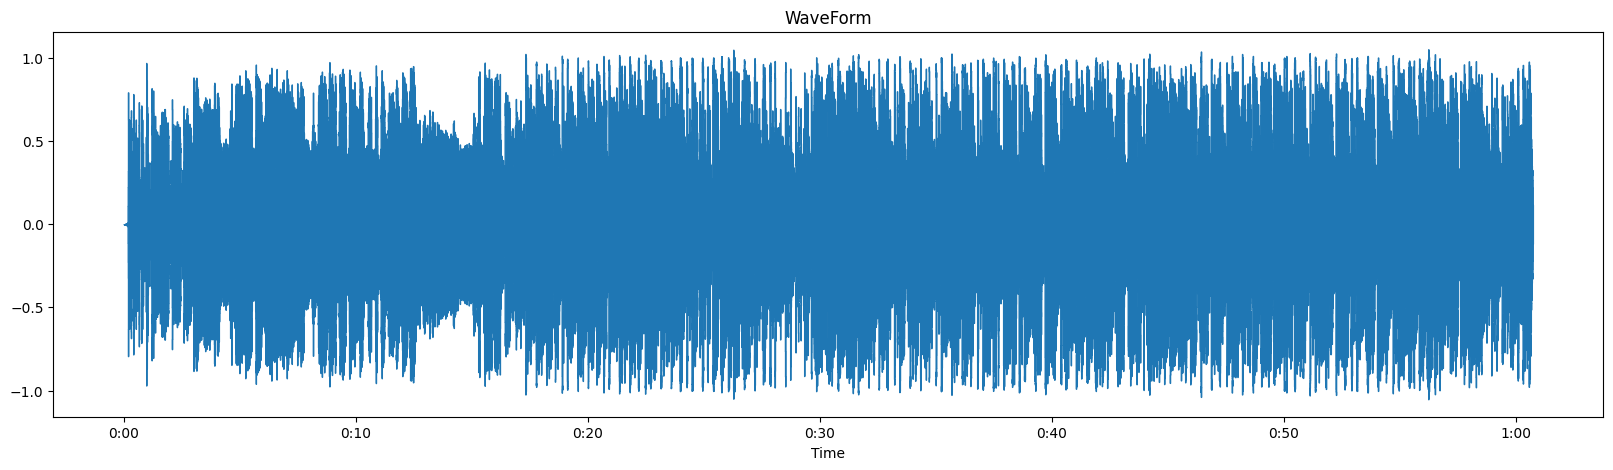

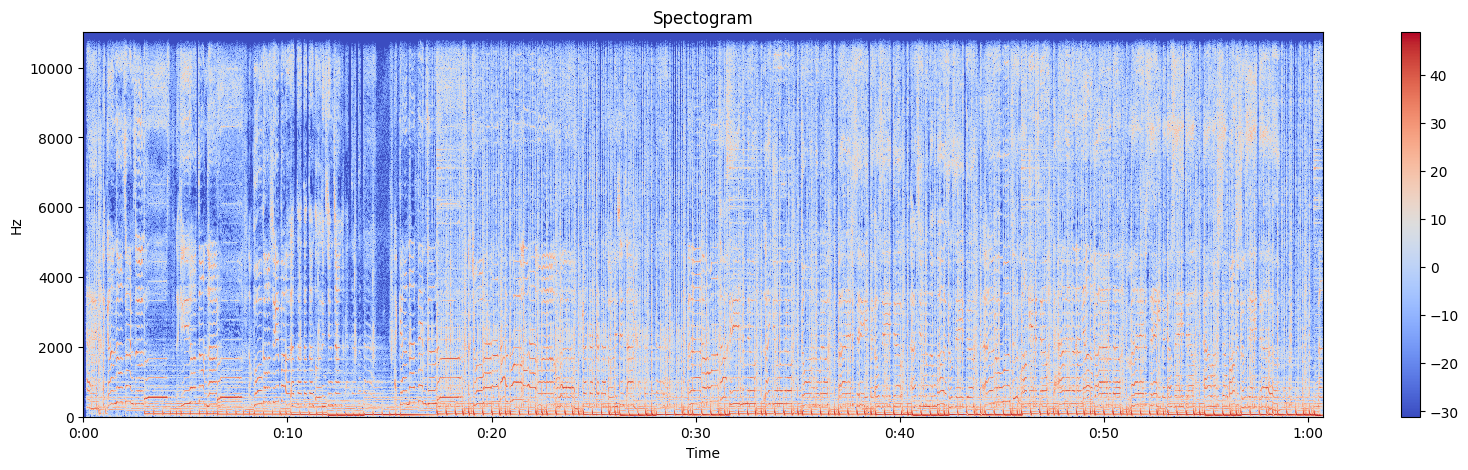

In [ ]:
Ditto.visualizeWaveForm()
Ditto.visualizeSpectogram()

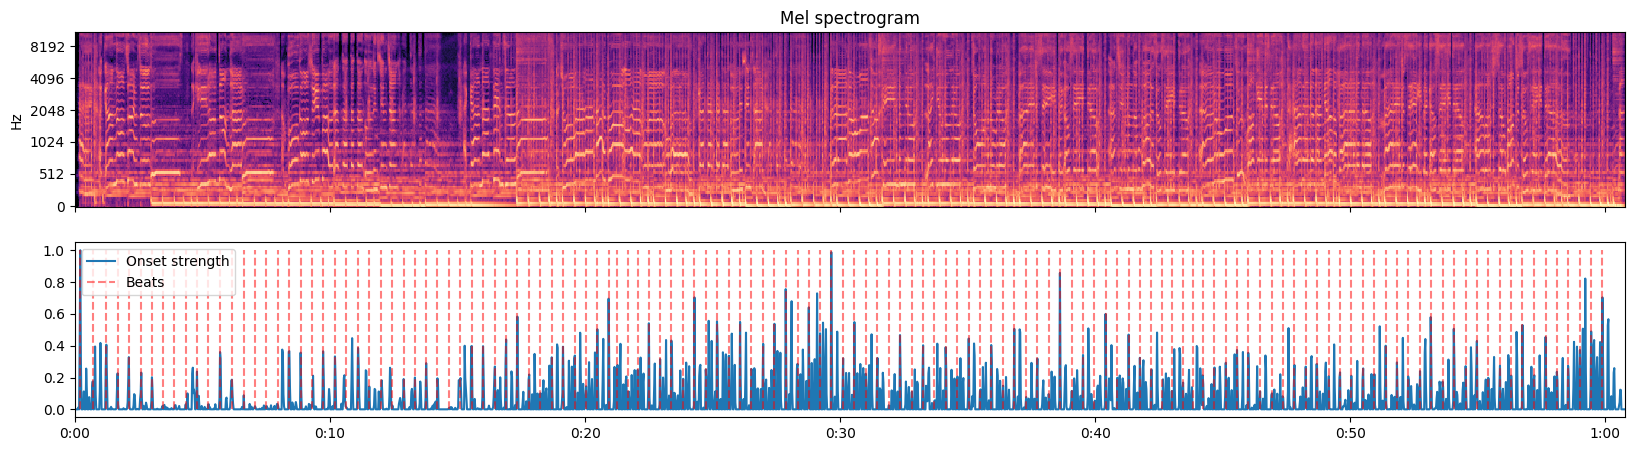

In [ ]:
dittoBPM = Ditto.extractBeatsPerMinute()
dittoFeatures.append(dittoBPM)
Ditto.visualizeBeatsPerMinute()

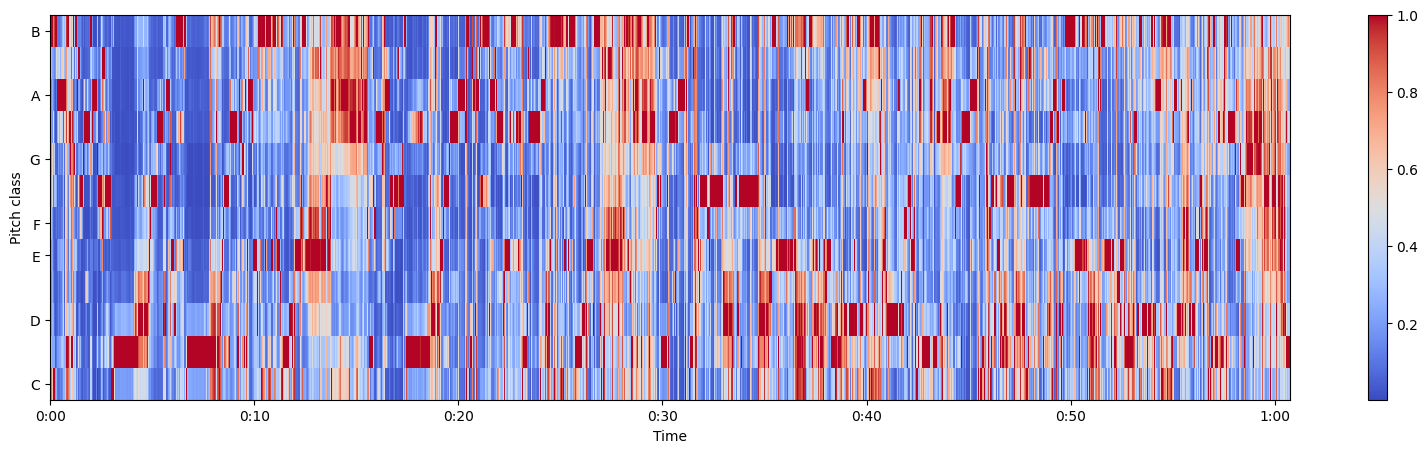

In [ ]:
dittoChroma = Ditto.extractChroma()
dittoFeatures.append(dittoChroma)
Ditto.visualizeChroma(dittoChroma)

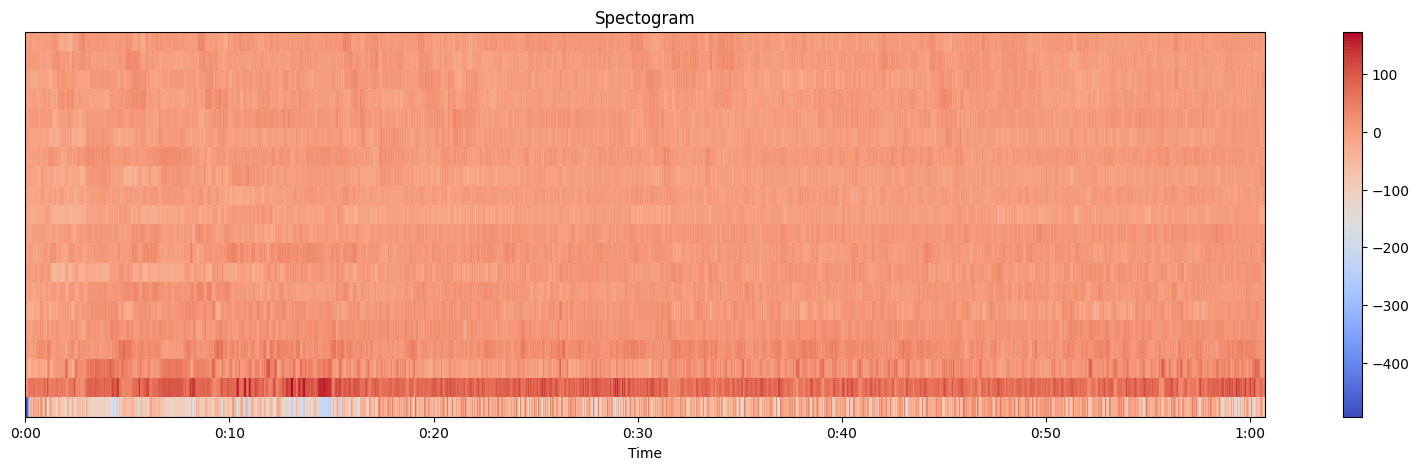

In [ ]:
dittoMFCC = Ditto.extractMFCC()
dittoFeatures.append(dittoMFCC)
Ditto.visualizeMFCC(dittoMFCC)

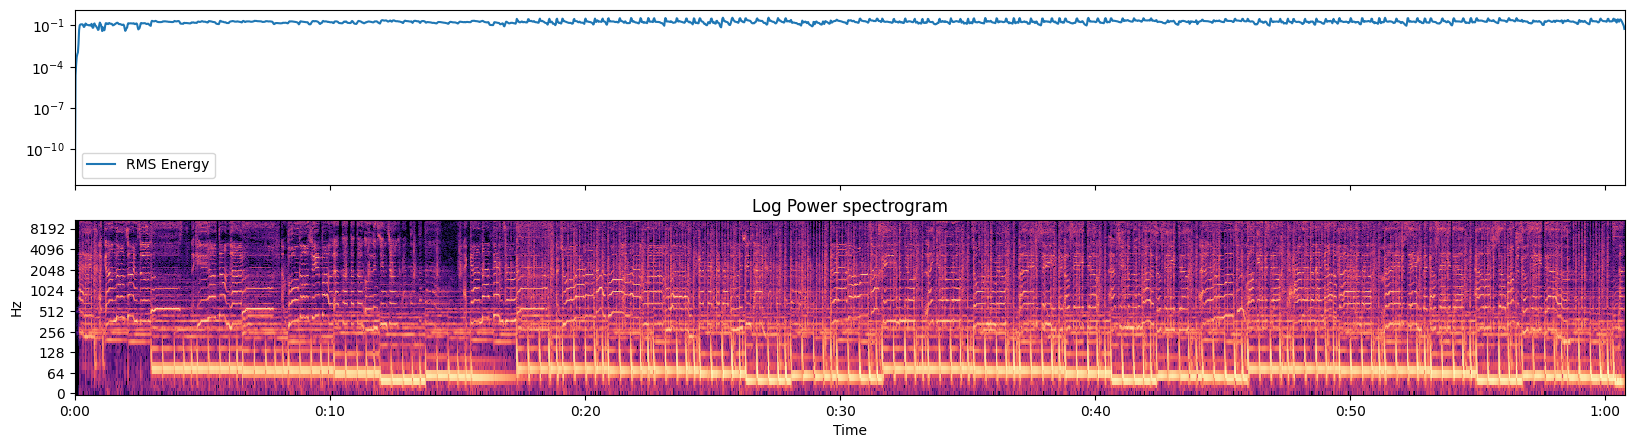

In [ ]:
magnitude, dittoRMS = Ditto.extractRootMeanSquare()
dittoFeatures.append(dittoRMS)
Ditto.visualizeRMS(magnitude, dittoRMS)

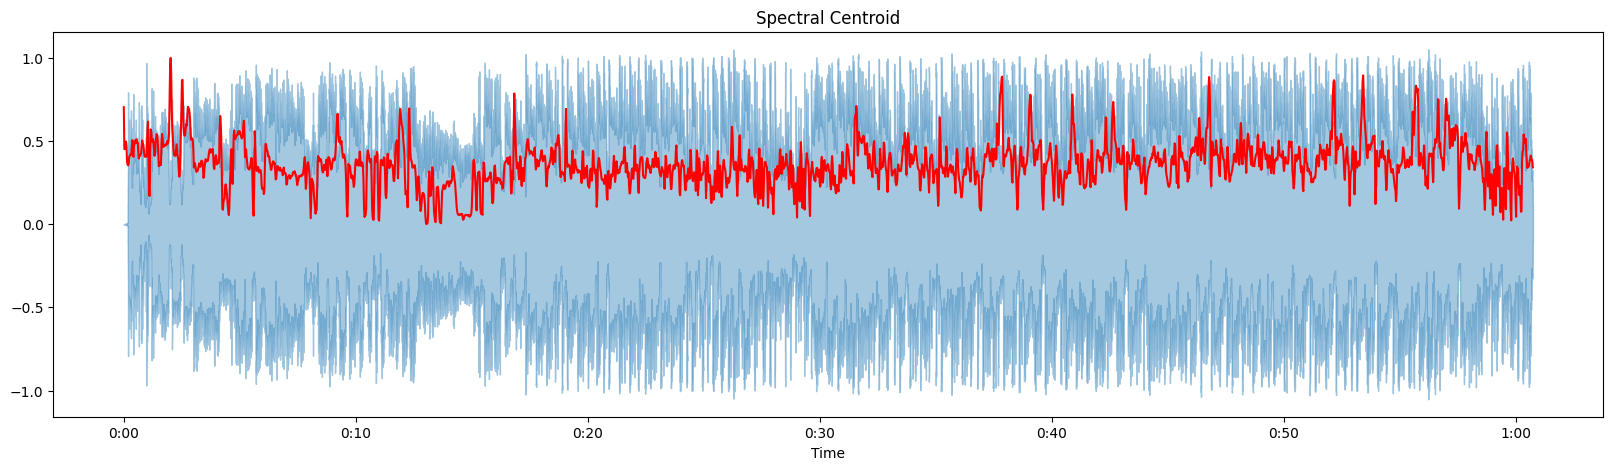

In [ ]:
dittoSpectralCentroid = Ditto.extractSpectralCentroid()
dittoFeatures.append(dittoSpectralCentroid)
Ditto.visualizeSpectralCentroid(dittoSpectralCentroid)

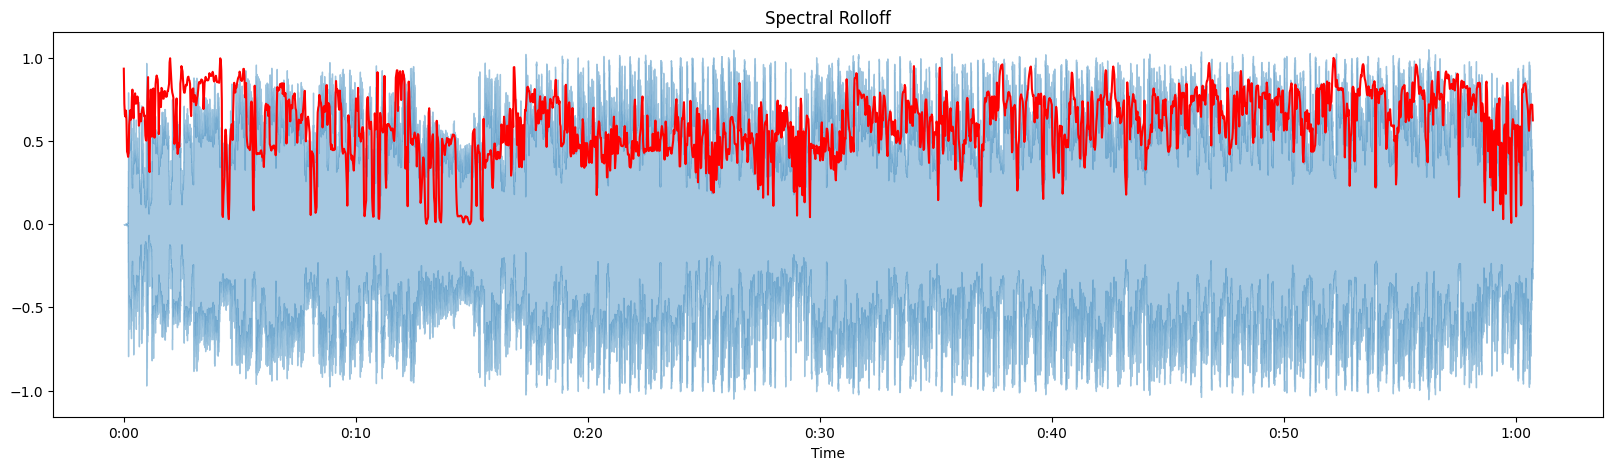

In [ ]:
dittoSpectralRolloff = Ditto.extractSpectralRolloff()
dittoFeatures.append(dittoSpectralRolloff)
Ditto.visualizeSpectralRolloff(dittoSpectralRolloff)

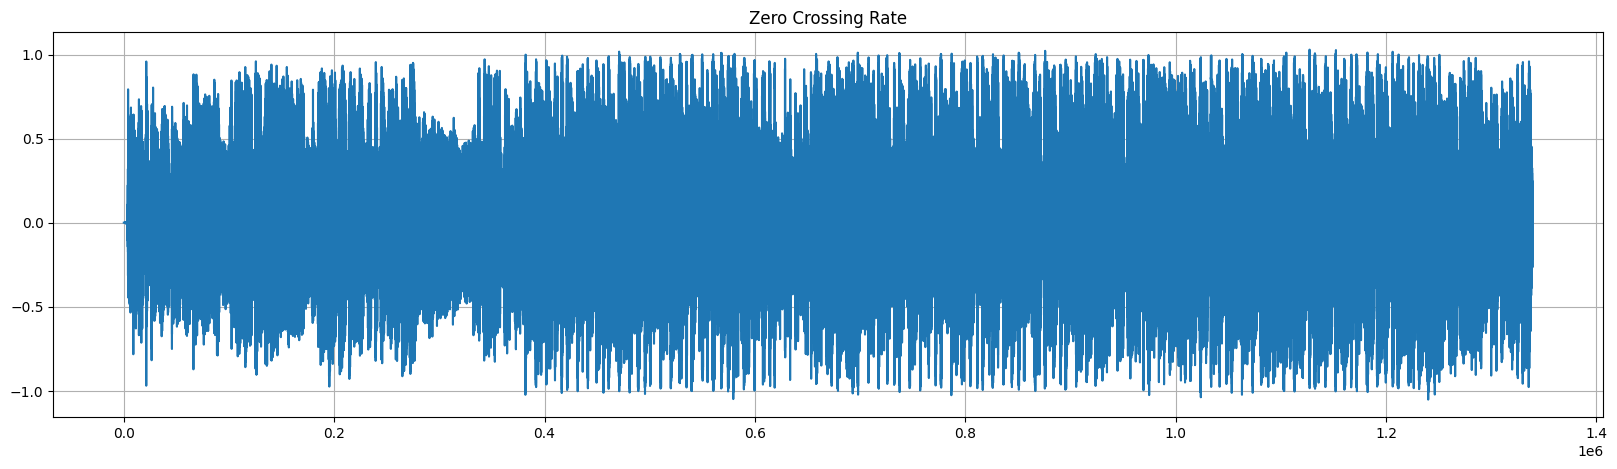

In [ ]:
dittoZCR = Ditto.extractZeroCrossingRate()
dittoFeatures.append(dittoZCR)
Ditto.visualizeZeroCrossingRate()

# Feature Extraction - Cold Cold Cold Man

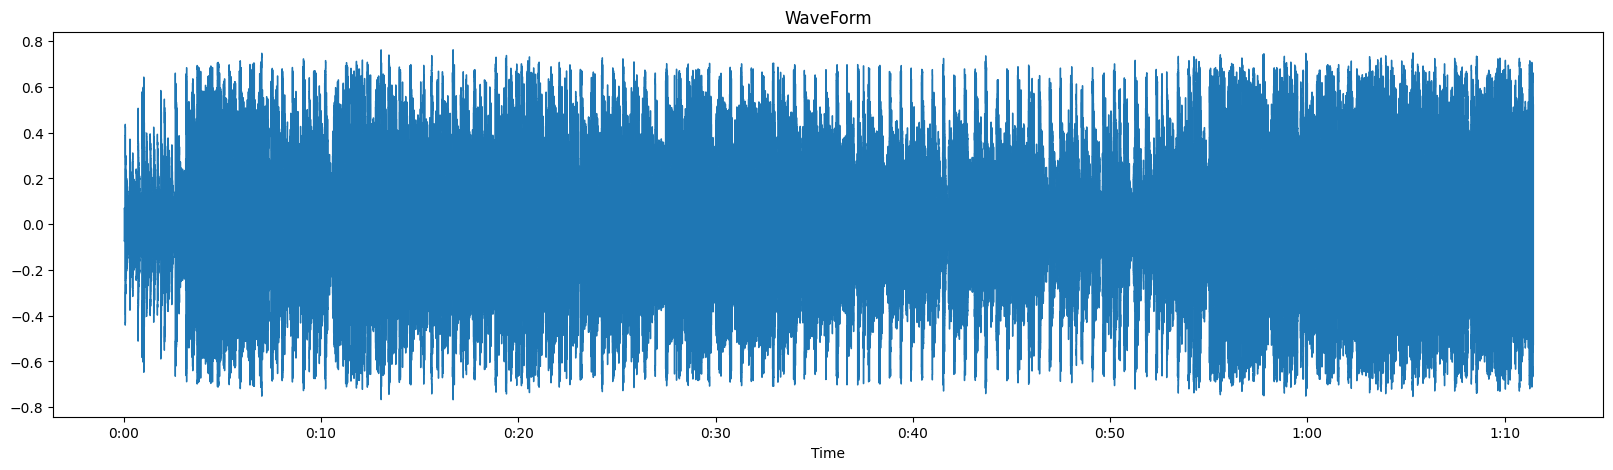

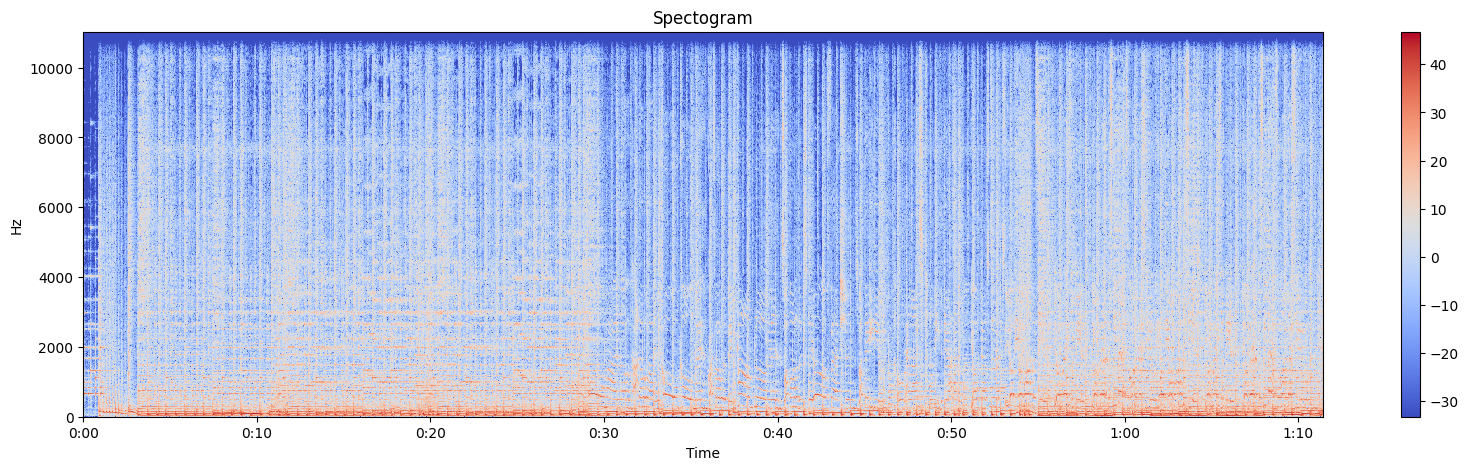

In [ ]:
C3Man.visualizeWaveForm()
C3Man.visualizeSpectogram()

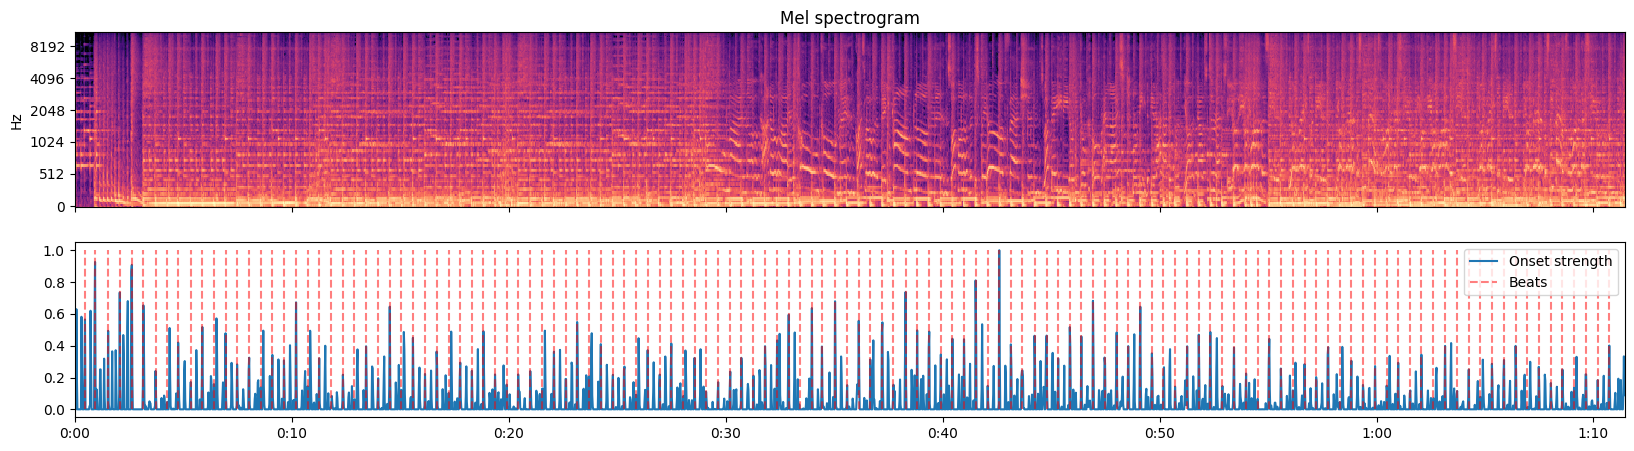

In [ ]:
coldBPM = C3Man.extractBeatsPerMinute()
coldManFeatures.append(coldBPM)
C3Man.visualizeBeatsPerMinute()

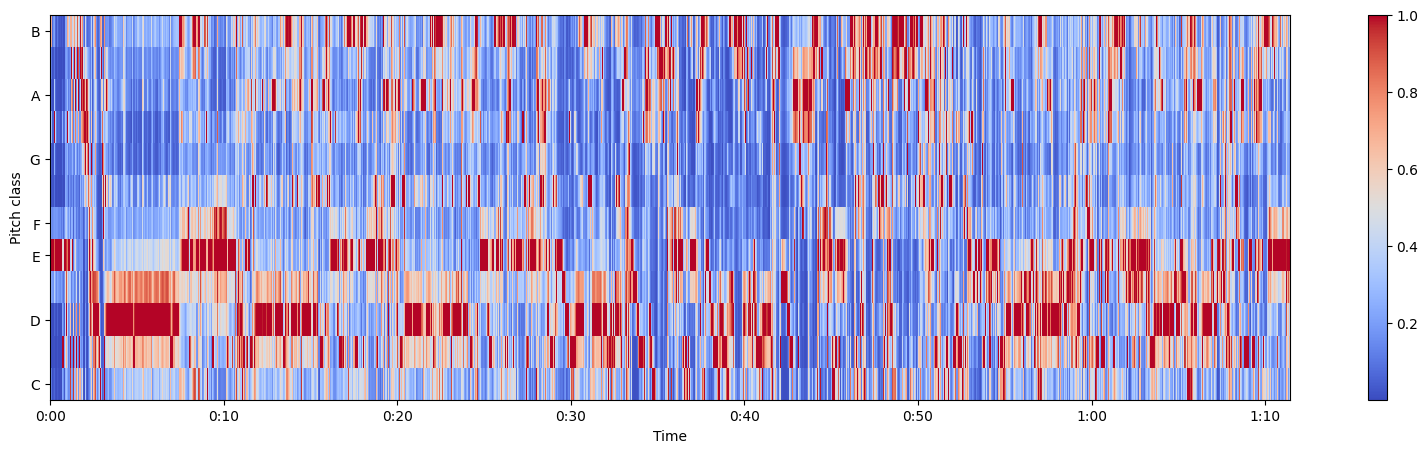

In [ ]:
coldChroma = C3Man.extractChroma()
coldManFeatures.append(coldChroma)
C3Man.visualizeChroma(coldChroma)

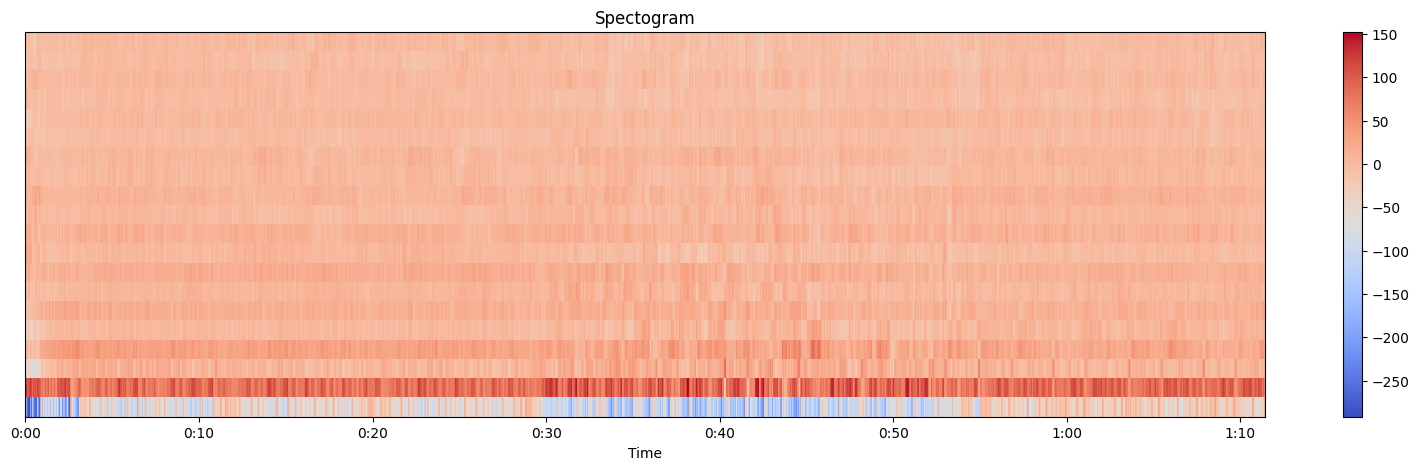

In [ ]:
coldMFCC = C3Man.extractMFCC()
coldManFeatures.append(coldMFCC)
C3Man.visualizeMFCC(coldMFCC)

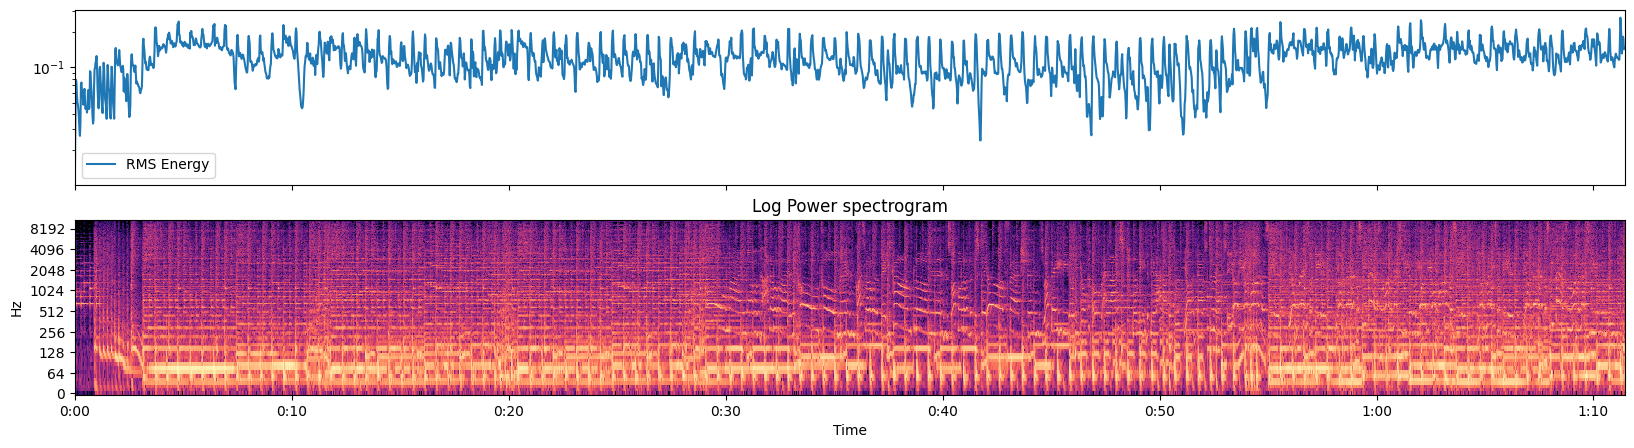

In [ ]:
magnitude, coldRMS = C3Man.extractRootMeanSquare()
coldManFeatures.append(coldRMS)
C3Man.visualizeRMS(magnitude, coldRMS)

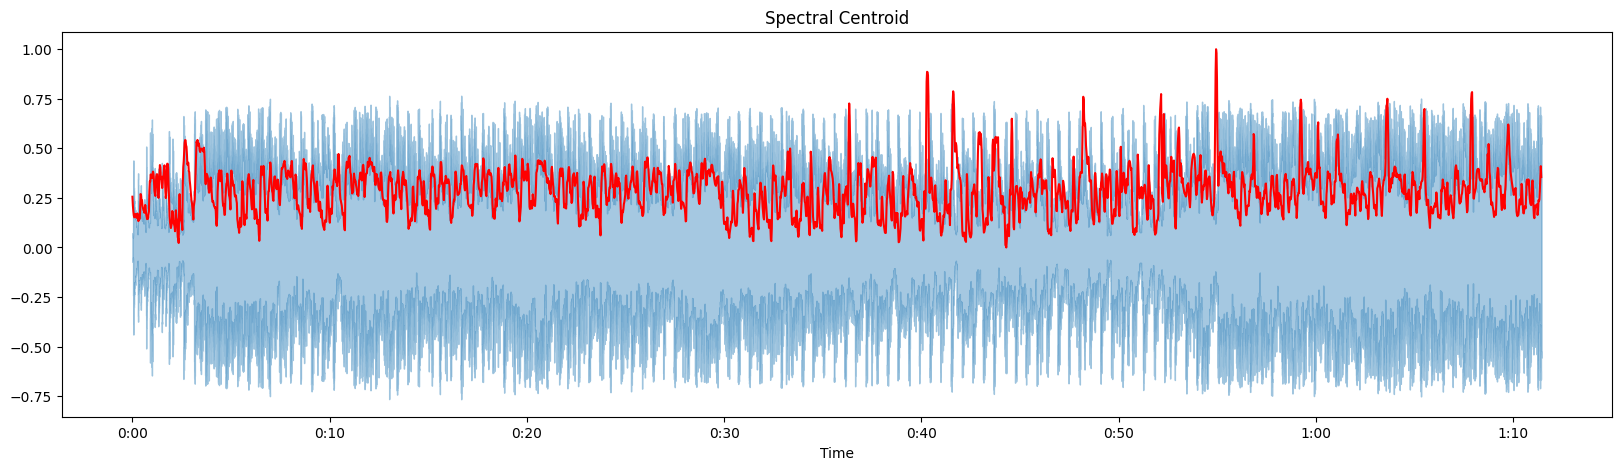

In [ ]:
coldSpectralCentroid = C3Man.extractSpectralCentroid()
coldManFeatures.append(coldSpectralCentroid)
C3Man.visualizeSpectralCentroid(coldSpectralCentroid)

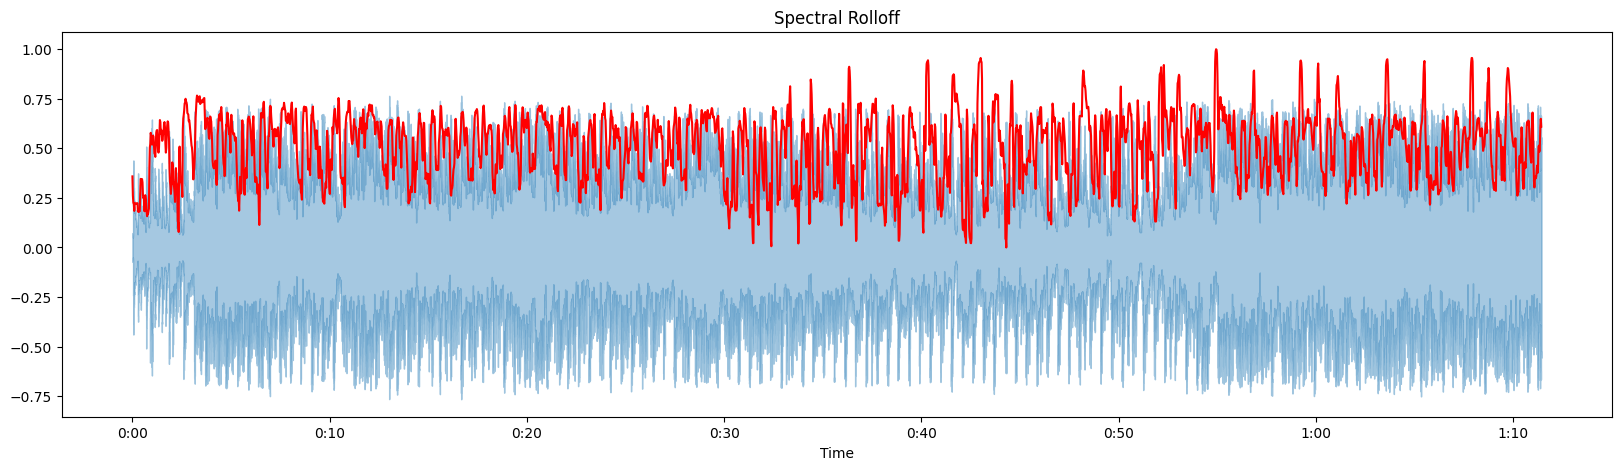

In [ ]:
coldSpectralRolloff = C3Man.extractSpectralRolloff()
coldManFeatures.append(coldSpectralRolloff)
C3Man.visualizeSpectralRolloff(coldSpectralRolloff)

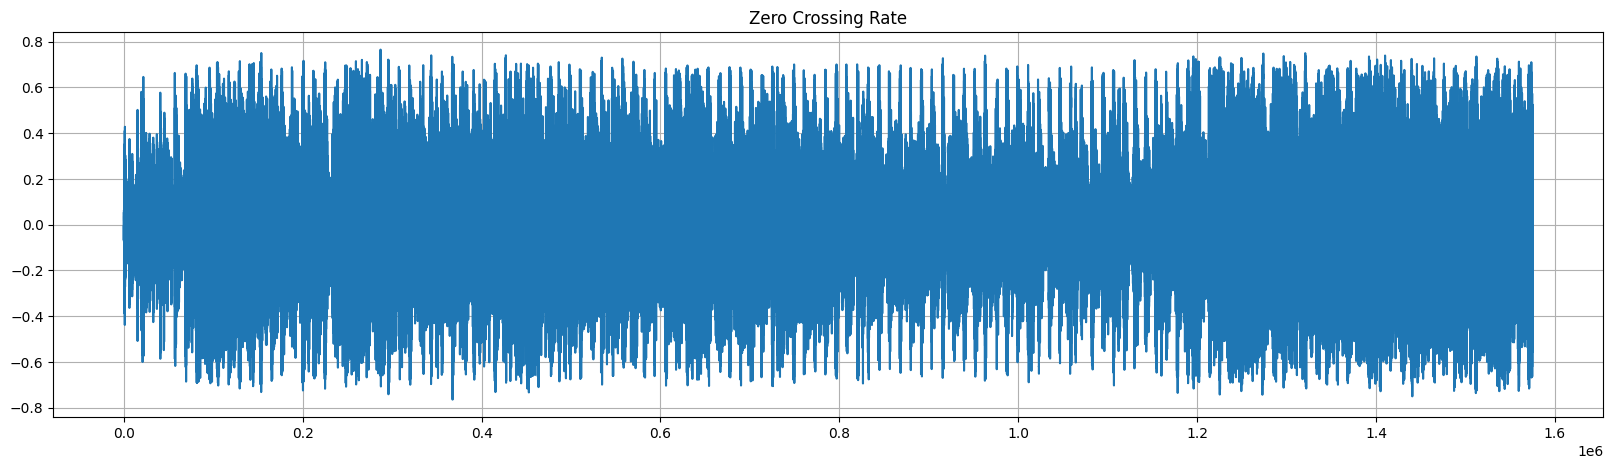

In [ ]:
coldZCR = C3Man.extractZeroCrossingRate()
coldManFeatures.append(coldZCR)
C3Man.visualizeZeroCrossingRate()

# Storing extracted data into .csv file.

In [ ]:
#pd converting to csv
def storeToCsv(extractedFeatureList, saveFileName='test', openMode='w+'):
    fileName = saveFileName + '.csv'
    data = extractedFeatureList
    columnMapping = {
        'Genre':data[0],
        'BeatsPerMinute(Tempo)':data[1],
    }
    nHeaderList = ['Chroma STFT ','MFCC ']
    for y in range(len(nHeaderList)):
        for x in range(len(data[y+2])):
            columnMapping[nHeaderList[y]+str(x+1)] = data[y+2][x].tolist()
    headerList = ['RootMeanSquare','SpectralCentroid','SpectralRolloff',]
    for z in range(len(headerList)):
        columnMapping[headerList[z]] = data[z+4].flatten().tolist()
    columnMapping['ZeroCrossingRate Sum'] = sum(data[7])
    # upper bound
    # print(columnMapping['Chroma STFT 12'])
    # print(columnMapping['MFCC 20'])
    # print(columnMapping['RootMeanSquare'])
    # print(columnMapping['SpectralCentroid'])
    # print(columnMapping['SpectralRolloff'])
    # print(columnMapping['ZeroCrossingRate Sum'])
    df = pd.DataFrame(columnMapping)
    df.to_csv(fileName, index=False)

In [ ]:
storeToCsv(dittoFeatures, saveFileName='DittoFeatures')

In [ ]:
storeToCsv(coldManFeatures, saveFileName='ColdColdColdManFeatures')

References:
* https://towardsdatascience.com/extract-features-of-music-75a3f9bc265d
* https://towardsdatascience.com/get-to-know-audio-feature-extraction-in-python-a499fdaefe42
* https://medium.com/@alexandro.ramr777/audio-files-to-dataset-by-feature-extraction-with-librosa-d87adafe5b64
* https://towardsdatascience.com/visualizing-audio-data-and-performing-feature-extraction-e1a489046000
